In [2]:
import mesa

# Data visualization tools.
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import logging

In [3]:
class UniverseSettings:
    def __init__(self, parameters):
        self.shards = parameters.get("shards", [parameters.get("shard_size_mb", 10_000) * parameters.get("shard_count", 100)])
        self.download_speed_mbps = parameters.get("download_speed_mbps", 100)
        self.worker_startup_time = parameters.get("worker_startup_time_sec", 1 * 60) # default: 1 minute
        self.worker_write_speed_mbps = parameters.get("worker_write_speed_mbps", 100)
        self.num_workers = parameters.get("n_workers", 1)
        self.model_timeout = parameters.get("model_timeout", 60 * 60) # default: 1 hour


class WorkerPolicies:
    def __init__(self, parameters):
        self.initial_lease_time = parameters.get("initial_lease_time_sec", 10 * 60) # default: 10 minutes
        self.split_disabled = parameters.get("split_disabled", True)
        self.split_at_end = parameters.get("split_at_end", True)
        self.split_ratio = parameters.get("split_ratio", 0.5)  # only relevant for split_at_end
        self.split_size = parameters.get("split_size_mb", 1_000)  # only relevant for split_at_start

In [4]:
class WorkItem:
    def __init__(self, shard_id, size):
        self.size = size
        self.shard_id = shard_id
        self.num_attempts = 0
        self.name = f"shard_{shard_id}"

In [5]:
class WorkCoordinatorState:
    def __init__(self, shards):
        work_items = [WorkItem(i+1, shard) for i, shard in enumerate(shards)]
        self.unclaimed = set(work_items)
        self.completed = set()
        self.claimed = set()
        self.logger = logging.getLogger(__name__)

    def claim_work(self):
        if len(self.unclaimed) == 0:
            return None
        work_item = self.unclaimed.pop()
        self.claimed.add(work_item)
        return work_item

    def release_work(self, work_item):
        self.claimed.remove(work_item)
        self.unclaimed.add(work_item)
        work_item.num_attempts += 1

    def complete_work(self, work_item):
        self.claimed.remove(work_item)
        self.completed.add(work_item)

    def swap(self, orig_work_item, new_work_items):
        self.logger.debug(f"Swapping {orig_work_item.name} for {[w.name for w in new_work_items]}")
        self.claimed.remove(orig_work_item)
        self.completed.add(orig_work_item)
        for work_item in new_work_items:
            self.unclaimed.add(work_item)

    def report_summary(self, verbose=False):
        self.logger.info(f"Unclaimed: {len(self.unclaimed)} ({sum(w.size for w in self.unclaimed)} mb)")
        self.logger.info(f"Claimed: {len(self.claimed)} ({sum(w.size for w in self.claimed)} mb)")
        self.logger.info(f"Completed: {len(self.completed)} ({sum(w.size for w in self.completed)} mb)")
        self.logger.debug(f"Unclaimed: {[w.name for w in self.unclaimed]}")
        self.logger.debug(f"Claimed: {[w.name for w in self.claimed]}")
        self.logger.debug(f"Completed: {[w.name for w in self.completed]}")

    def is_complete(self):
        return len(self.unclaimed) == 0 and len(self.claimed) == 0

In [6]:
from enum import Enum
WorkerState = Enum("WorkerState", ["STARTING", "DOWNLOADING", "WRITING"])

class WorkerAgent(mesa.Agent):
    def __init__(self, unique_id, model, workerPolicies, startup_time, download_speed, write_speed):
        # Pass the parameters to the parent class.
        super().__init__(unique_id, model)
        self.policies = workerPolicies
        self.startup_time = startup_time
        self.download_speed = download_speed
        self.write_speed = write_speed
        self.logger = logging.getLogger(__name__)

        self.age = 0
        self.work_item = None
        self.state = WorkerState.STARTING
        self.downloaded = 0
        self.written = 0

        self.lease_expiration = self.policies.initial_lease_time # this isn't exactly accurate, but it'll be set when we get a work item
        self._report("Starting up")

    def _report(self, message):
      self.logger.debug(f"  {self.unique_id}@{self.age}: {message}")

    def step(self):
      self.age += 1

      if self.age >= self.lease_expiration:
        self._handle_lease_expiration()
        return

      # Get through start up time
      if self.age < self.startup_time:
        return
      if self.age == self.startup_time:
        self._report("Completed startup time")
        self.state = WorkerState.DOWNLOADING

      # Attempt to claim work
      if self.work_item is None:
        self.work_item = self.model.workCoordinatorState.claim_work()
        if self.work_item is not None:
          self.lease_expiration = self.age + (self.policies.initial_lease_time * 2 ** self.work_item.num_attempts)
          self._report(f"Claimed work {self.work_item.name} ({self.work_item.size} mb) (attempts: {self.work_item.num_attempts}). Lease expires at {self.lease_expiration}")
        self.download_time = 0
        self.writing_time = 0
      # If still no work item, die
      if self.work_item is None:
        self._report("No work was claimed, shutting down")
        self.remove()
        return

      # Get through download time
      if self.state == WorkerState.DOWNLOADING:
        if self.downloaded == 0:
          self._report(f"Starting download. Expected to complete at time {self.age + (self.work_item.size // self.download_speed)}. Lease expires at {self.lease_expiration}")
        if self.downloaded < self.work_item.size:
          self.downloaded += self.download_speed
          return
        if self.downloaded >= self.work_item.size:
          self._report("Completed download")
          self.state = WorkerState.WRITING

      # Do split-at-start if in policy
      if not self.policies.split_disabled and self.policies.split_at_end == False:
        if self.work_item.size > self.policies.split_size:
          self._split_at_start()
          return

      # Get through writing time
      if self.state == WorkerState.WRITING:
        if self.written == 0:
          self._report(f"Starting write. Expected to complete at time {self.age + (self.work_item.size // self.write_speed)}. Lease expires at {self.lease_expiration}")
        if self.written < self.work_item.size:
          self.written += self.write_speed
          return
        if self.written >= self.work_item.size:
          # Mark as completed
          self._report("Completed work")
          self.model.workCoordinatorState.complete_work(self.work_item)
          self.work_item = None
          self.remove()


    def _handle_lease_expiration(self):
      if self.work_item is None:
        self._report("Lease expired, but no work was claimed. This is maybe a bug state?")
        self.remove()
        return
      self._report(f"Lease expired for work item {self.work_item.name}")
      if self.policies.split_disabled or self.policies.split_at_end == False:
        self._report("Releasing work")
        self.model.workCoordinatorState.release_work(self.work_item)
      else:
        self._split_at_end()

      self.work_item = None
      self.remove()
      return

    def _split_at_start(self):
      n_successors = self.work_item.size // self.policies.split_size
      remainder = self.work_item.size % self.policies.split_size
      successors = [WorkItem(self.work_item.shard_id * 10 + i, self.policies.split_size) for i in range(n_successors)] + [WorkItem(self.work_item.shard_id * 10 + n_successors, remainder)]
      self._report(f"Splitting work into {len(successors)} work items of up to {self.policies.split_size}mb and shutting down")
      self.model.workCoordinatorState.swap(self.work_item, successors)
      self.work_item = None
      self.remove()
      return

    def _split_at_end(self):
      if self.written == 0:
        # No progress was made. Release this item so it can be grabbed with a longer lease
        self._report("No progress was made. Releasing work")
        self.model.workCoordinatorState.release_work(self.work_item)
        return
      remainder = self.work_item.size - self.written
      size_of_successors = remainder * self.policies.split_ratio
      n_successors = round(1 / self.policies.split_ratio)
      self._report(f"Splitting work into {n_successors} of size {size_of_successors}")
      successors = [WorkItem(self.work_item.shard_id * 10 + i+1, size_of_successors) for i in range(n_successors)]
      self.model.workCoordinatorState.swap(self.work_item, successors)

In [7]:
from random import randint

def count_shards(shard_set):
    return len(shard_set)

def size_of_shards(shard_set):
    return sum(w.size for w in shard_set)

def all_remaining_work(model):
  unclaimed = size_of_shards(model.workCoordinatorState.unclaimed)
  claimed_and_uncompleted = sum(((w.work_item.size - w.written) for w in model.schedule.agents if w.work_item is not None))
  return unclaimed + claimed_and_uncompleted

class RFSModel(mesa.Model):
    """A model with some number of agents."""
    def __init__(self, universeSettings, workerPolicies):
        super().__init__()
        # Create scheduler and assign it to the model
        self.schedule = mesa.time.BaseScheduler(self)

        self.workerPolicies = workerPolicies
        self.universeSettings = universeSettings
        self.num_agents = universeSettings.num_workers
        self.time_out = universeSettings.model_timeout
        self.logger = logging.getLogger(__name__)

        # Initialize work coordinator state object from shards
        self.workCoordinatorState = WorkCoordinatorState(universeSettings.shards)

        # Create workers
        for _ in range(self.num_agents):
            a = WorkerAgent(randint(0, 10000), self, workerPolicies, universeSettings.worker_startup_time, universeSettings.download_speed_mbps, universeSettings.worker_write_speed_mbps)
            # Add the agent to the scheduler
            self.schedule.add(a)

        self.datacollector = mesa.DataCollector(
            model_reporters={
                "time": lambda x: x.schedule.time,
                "n_unclaimed": lambda x: count_shards(x.workCoordinatorState.unclaimed),
                "n_claimed": lambda x: count_shards(x.workCoordinatorState.claimed),
                "n_completed": lambda x: count_shards(x.workCoordinatorState.completed),
                "size_unclaimed": lambda x: size_of_shards(x.workCoordinatorState.unclaimed),
                "size_claimed": lambda x: size_of_shards(x.workCoordinatorState.claimed),
                "size_completed": lambda x: size_of_shards(x.workCoordinatorState.completed),
                "workers": lambda x: x.schedule.get_agent_count(),
                "workers_starting": lambda x: len([a for a in x.schedule.agents if a.state == WorkerState.STARTING]),
                "workers_downloading": lambda x: len([a for a in x.schedule.agents if a.state == WorkerState.DOWNLOADING]),
                "workers_writing": lambda x: len([a for a in x.schedule.agents if a.state == WorkerState.WRITING]),
                "mb_written": lambda x: sum(a.write_speed for a in x.schedule.agents if a.state == WorkerState.WRITING),
                "mb_downloaded": lambda x: sum(a.download_speed for a in x.schedule.agents if a.state == WorkerState.DOWNLOADING),
                "all_remaining_work": lambda x: all_remaining_work(x)
            },
            agent_reporters={"Age": "age"}
        )

    def step(self):
        """Advance the model by one step."""
        # The model's step will go here for now this will call the step method of each agent and print the agent's unique_id
        if self.workCoordinatorState.is_complete():
          self.logger.warning(f"All work completed @ time {self.schedule.time}")
          self.running = False
        self.datacollector.collect(self)

        self.schedule.step()
        if len(self.agents) < self.num_agents:
            self.logger.debug("Short on workers. Creating new ones.")
            a = WorkerAgent(randint(0, 10000), self, self.workerPolicies, self.universeSettings.worker_startup_time,
                            self.universeSettings.download_speed_mbps, self.universeSettings.worker_write_speed_mbps)
            self.schedule.add(a)

        if self.schedule.time % 60 == 0:
          self.logger.info(f"GLOBAL TIME: {self.schedule.time // 60} minutes")
          self.workCoordinatorState.report_summary()

        if self.schedule.time >= self.time_out:
          self.logger.warning(f"Model timed out after {self.schedule.time} seconds")
          self.running = False

In [8]:
current_policy = WorkerPolicies({
    "initial_lease_time_sec": 10 * 60,
    "split_disabled": True
})
test_universe = UniverseSettings({
    "shards": [5000],
    "download_speed_mbps": 100,
    "worker_startup_time_sec": 10,
    "worker_write_speed_mbps": 100,
    "n_workers": 1,
    "model_timeout": 60 * 60,
})
model = RFSModel(test_universe, current_policy)
model.run_model()
model.datacollector.get_model_vars_dataframe()

All work completed @ time 110


,time,n_unclaimed,n_claimed,n_completed,size_unclaimed,size_claimed,size_completed,workers,workers_starting,workers_downloading,workers_writing,mb_written,mb_downloaded,all_remaining_work
0,0,1,0,0,5000,0,0,1,1,0,0,0,0,5000
1,1,1,0,0,5000,0,0,1,1,0,0,0,0,5000
2,2,1,0,0,5000,0,0,1,1,0,0,0,0,5000
3,3,1,0,0,5000,0,0,1,1,0,0,0,0,5000
4,4,1,0,0,5000,0,0,1,1,0,0,0,0,5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,106,0,1,0,0,5000,0,1,0,0,1,100,0,300
107,107,0,1,0,0,5000,0,1,0,0,1,100,0,200
108,108,0,1,0,0,5000,0,1,0,0,1,100,0,100
109,109,0,1,0,0,5000,0,1,0,0,1,100,0,0


In [11]:
def run_and_plot_shard_progress(universe_settings, worker_policies, log_level='INFO'):
  logging.getLogger().setLevel(log_level)
  model = RFSModel(universe_settings, worker_policies)
  model.run_model()
  data = model.datacollector.get_model_vars_dataframe()
  print(f"Remaining work: {int(data['all_remaining_work'].iloc[-1] / 1000 )}gb")
  plt.figure(figsize=(15, 5))

  # Shard state
  plt.subplot(1, 3, 1)
  plt.plot(data['time'], data[["n_unclaimed", "n_claimed", "n_completed"]])
  plt.title("Shard States")
  plt.xlabel("Time")
  plt.ylabel("Count")
  plt.legend(["Unclaimed", "Claimed", "Completed"])

  # Writing and downloading values
  plt.subplot(1, 3, 2)
  plt.plot(data['time'], np.cumsum(data['mb_written']), label='Cumulative MB Written')
  plt.plot(data['time'], np.cumsum(data['mb_downloaded']), label='Cumulative MB Downloaded')
  plt.plot(data['time'], data['all_remaining_work'], label='Remaining Data in MB')
  plt.xlabel('Time')
  plt.ylabel('MB')
  plt.title('Written and Downloaded over time')
  plt.legend()

  # Worker state
  plt.subplot(1, 3, 3)
  plt.plot(data['time'], data[["workers_starting", "workers_downloading", "workers_writing"]])
  plt.title("Worker States")
  plt.xlabel("Time")
  plt.ylabel("Count")
  plt.legend(["Starting", "Downloading", "Writing"])
  plt.tight_layout()
  plt.show()
  return data

All work completed @ time 2961


Starting work for each model: 550 gb
Full Shard Policy
Remaining work: 0gb


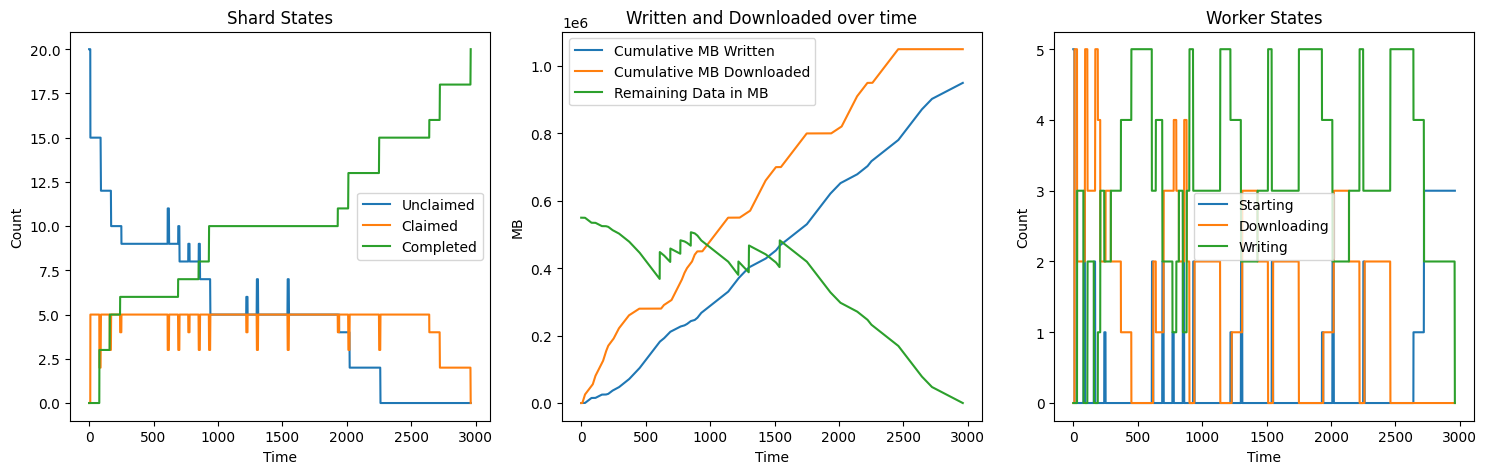

All work completed @ time 1971


Checkpoint Policy
Remaining work: 0gb


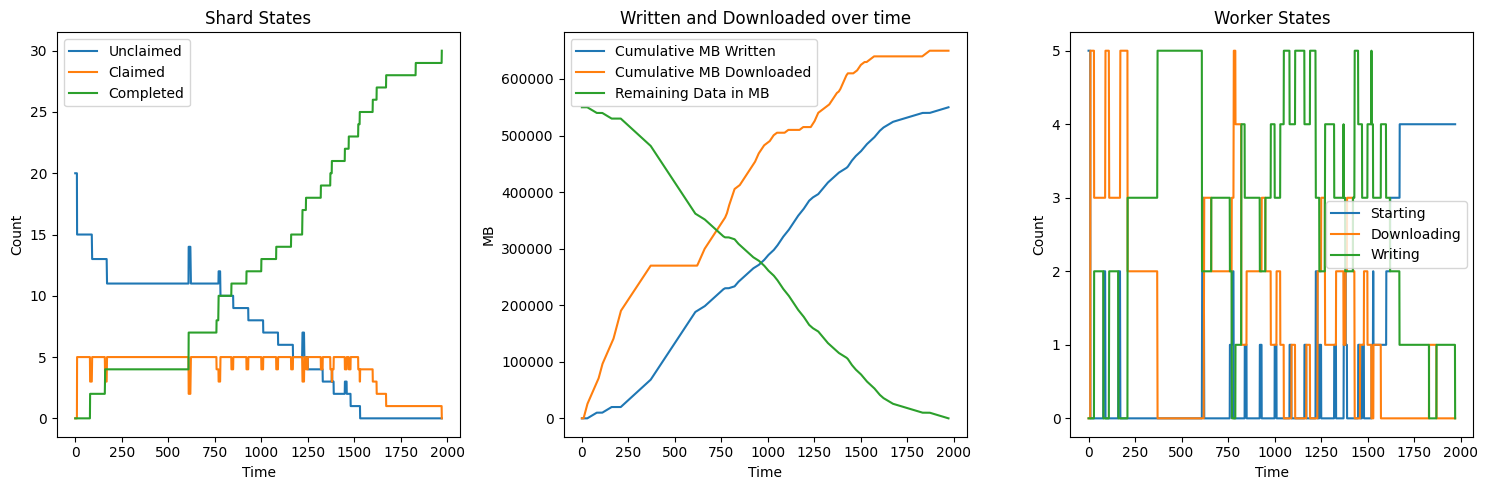

All work completed @ time 1704


Binary Split Policy
Remaining work: 0gb


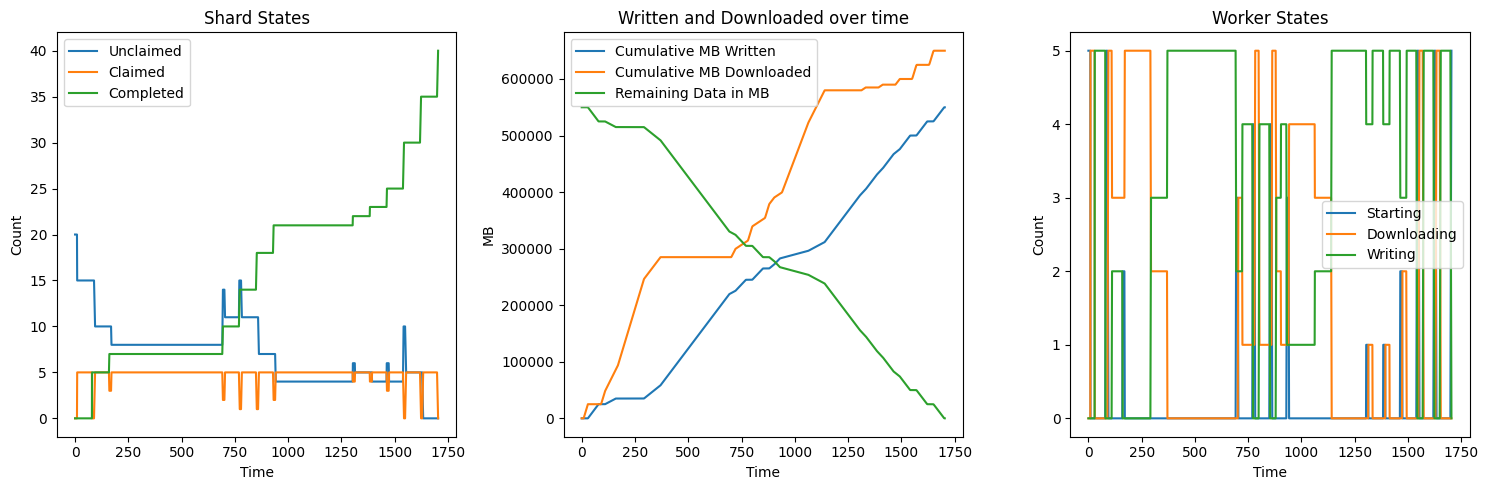

Aggressive Preemptive Split Policy (split to 2gb)


All work completed @ time 2624


Remaining work: 0gb


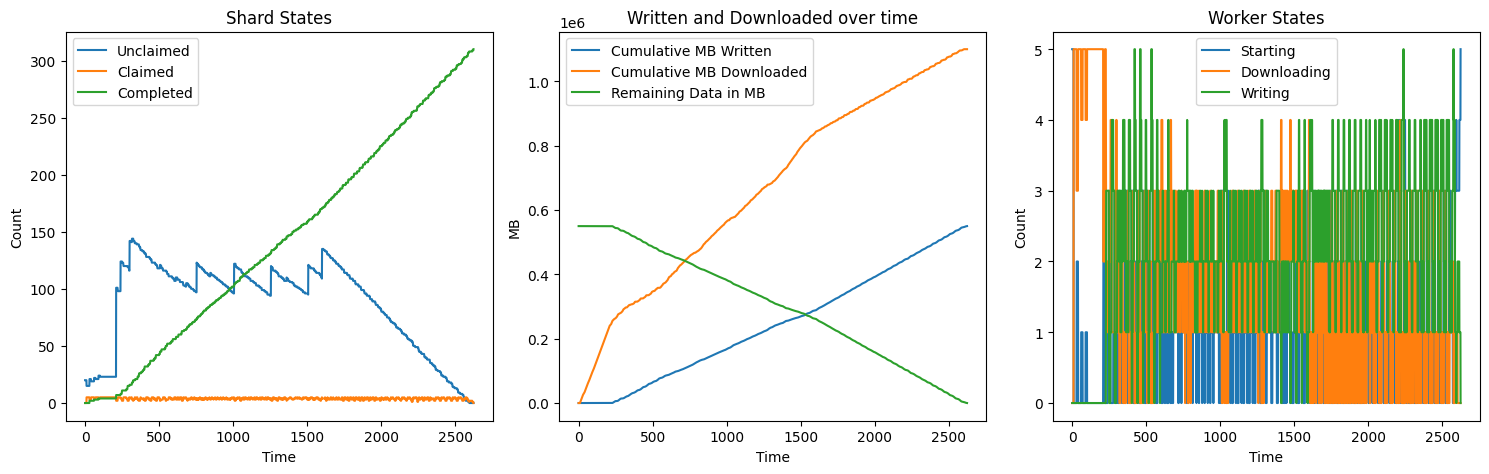

Conservative Preemptive Split Policy (split to 20gb)


All work completed @ time 2621


Remaining work: 0gb


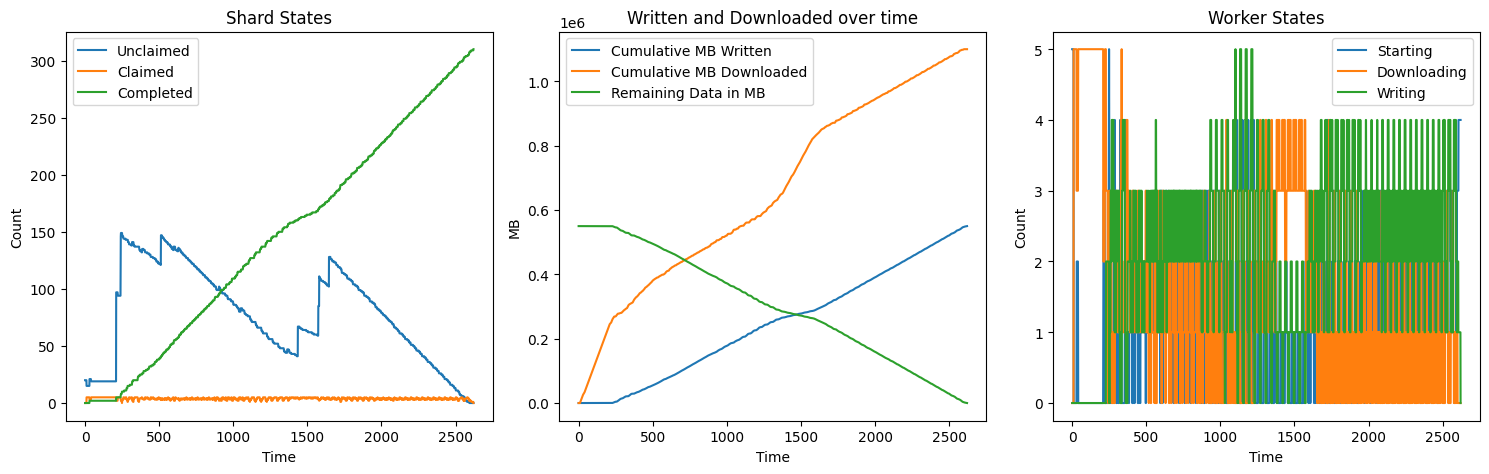

In [14]:
basic_universe = UniverseSettings({
    "shards": ([5000] * 10) + ([50_000] * 10),
    "download_speed_mbps": 250,
    "worker_startup_time_sec": 10,
    "worker_write_speed_mbps": 100,
    "n_workers": 5,
    "model_timeout": 60 * 60,
})
full_shard_policy = WorkerPolicies({
    "initial_lease_time_sec": 10 * 60,
    "split_disabled": True
})
checkpoint_policy = WorkerPolicies({
    "initial_lease_time_sec": 10 * 60,
    "split_disabled": False,
    "split_at_end": True,
    "split_ratio": 1,
})
binary_split_policy = WorkerPolicies({
    "initial_lease_time_sec": 10 * 60,
    "split_disabled": False,
    "split_at_end": True,
    "split_ratio": 0.5,
})
aggressive_preemptive_split_policy = WorkerPolicies({
    "initial_lease_time_sec": 10 * 60,
    "split_disabled": False,
    "split_at_end": False,
    "split_size_mb": 2_000,
})
conservative_preemptive_split_policy = WorkerPolicies({
    "initial_lease_time_sec": 10 * 60,
    "split_disabled": False,
    "split_at_end": False,
    "split_size_mb": 20_000,
})
print(f"Starting work for each model: {sum(basic_universe.shards) // 1000 } gb")
print("Full Shard Policy")
_ = run_and_plot_shard_progress(basic_universe, full_shard_policy, 'WARN')
print("Checkpoint Policy")
_ = run_and_plot_shard_progress(basic_universe, checkpoint_policy, 'WARN')
print("Binary Split Policy")
_ = run_and_plot_shard_progress(basic_universe, binary_split_policy, 'WARN')
print("Aggressive Preemptive Split Policy (split to 2gb)")
_ = run_and_plot_shard_progress(basic_universe, aggressive_preemptive_split_policy, 'WARN')
print("Conservative Preemptive Split Policy (split to 20gb)")
_ = run_and_plot_shard_progress(basic_universe, aggressive_preemptive_split_policy, 'WARN')

Starting work for each model: 2000 gb
Full Shard Policy


All work completed @ time 5754


Remaining work: 0gb


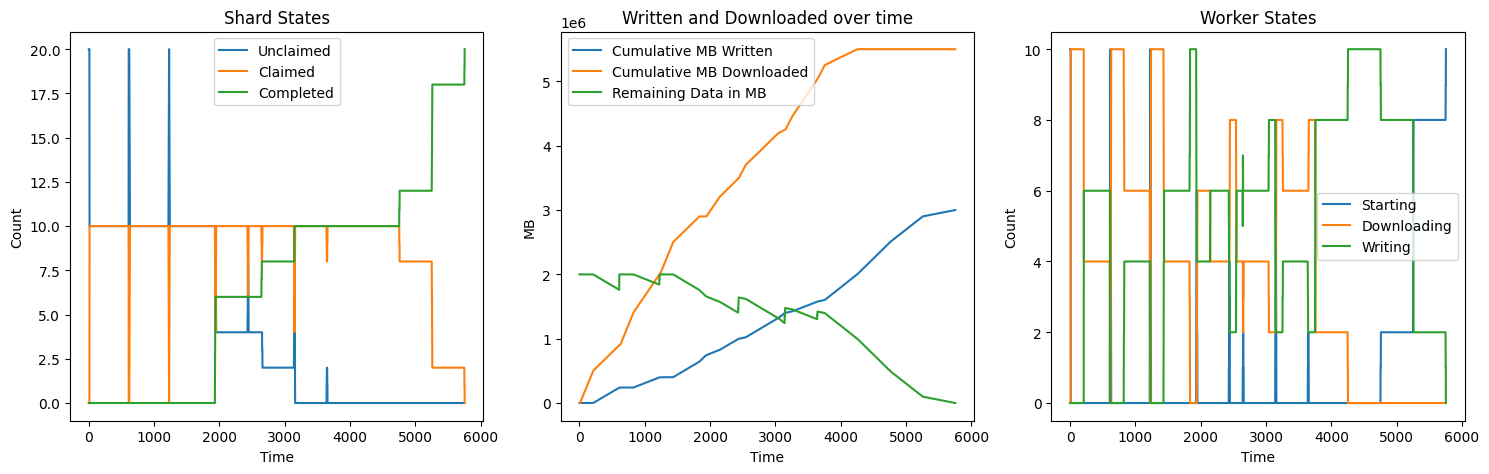

All work completed @ time 4572


Checkpoint Policy
Remaining work: 0gb


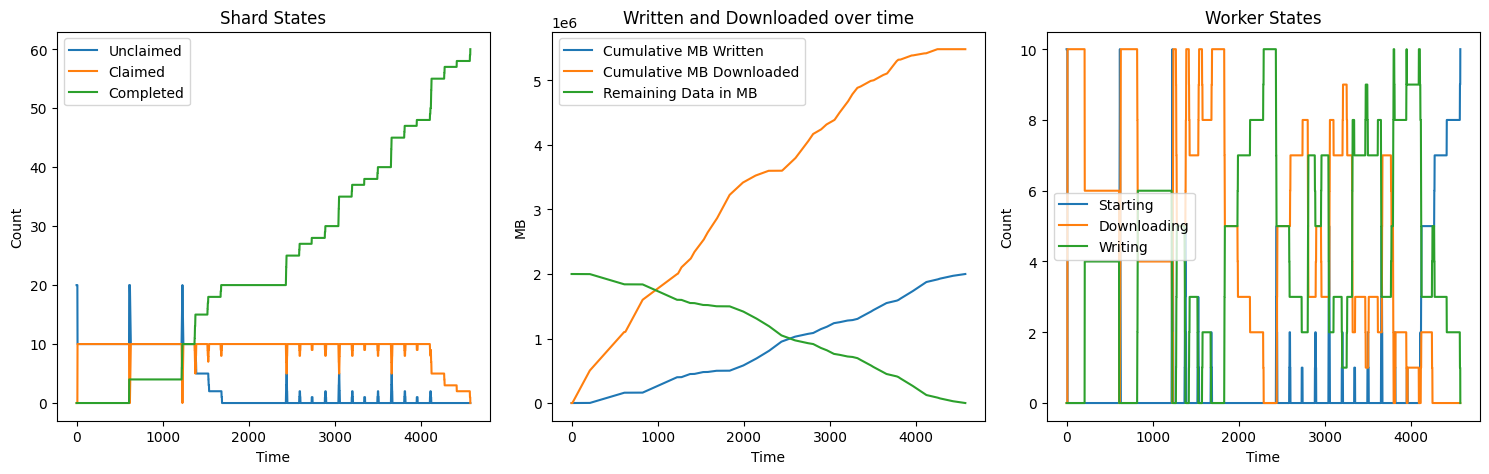

All work completed @ time 4003


Binary Split Policy
Remaining work: 0gb


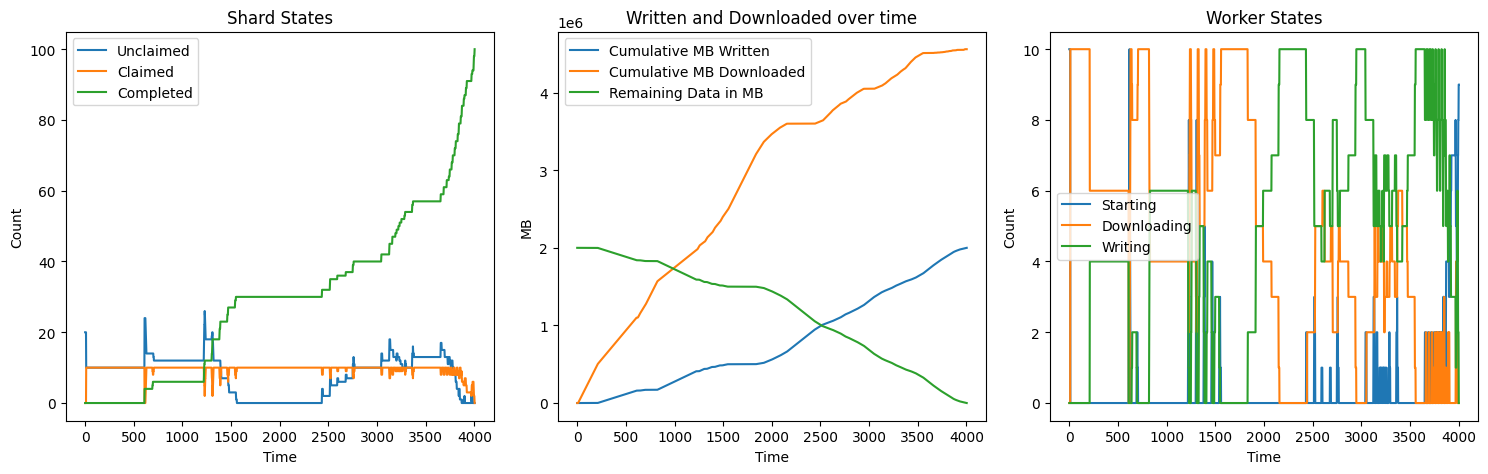

Aggressive Preemptive Split Policy (split to 2gb)


All work completed @ time 5291


Remaining work: 0gb


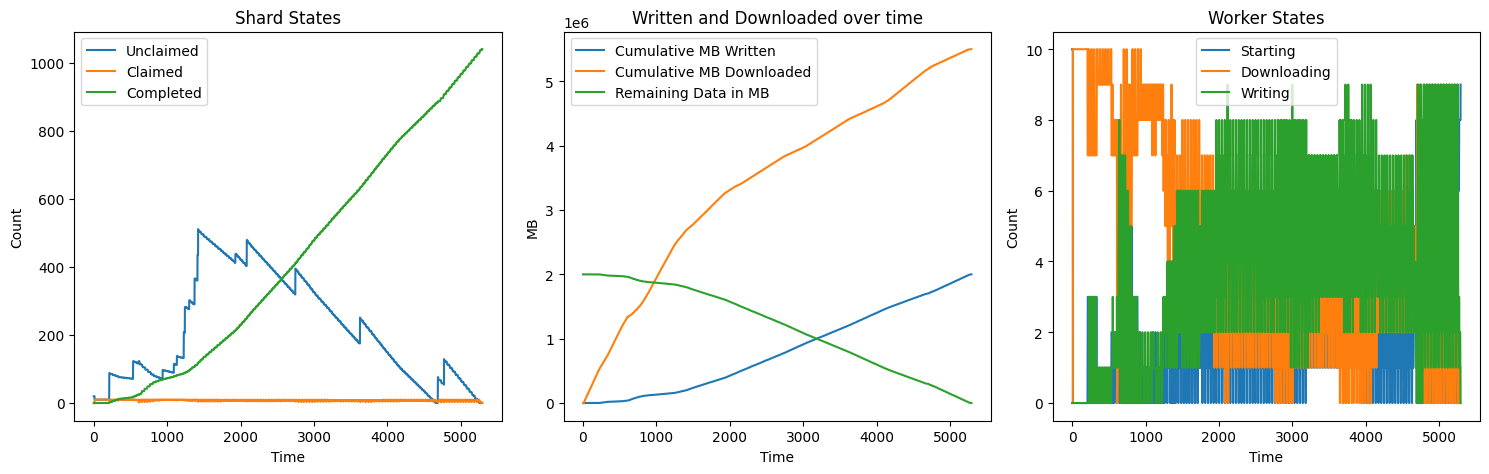

Conservative Preemptive Split Policy (split to 20gb)


All work completed @ time 5276


Remaining work: 0gb


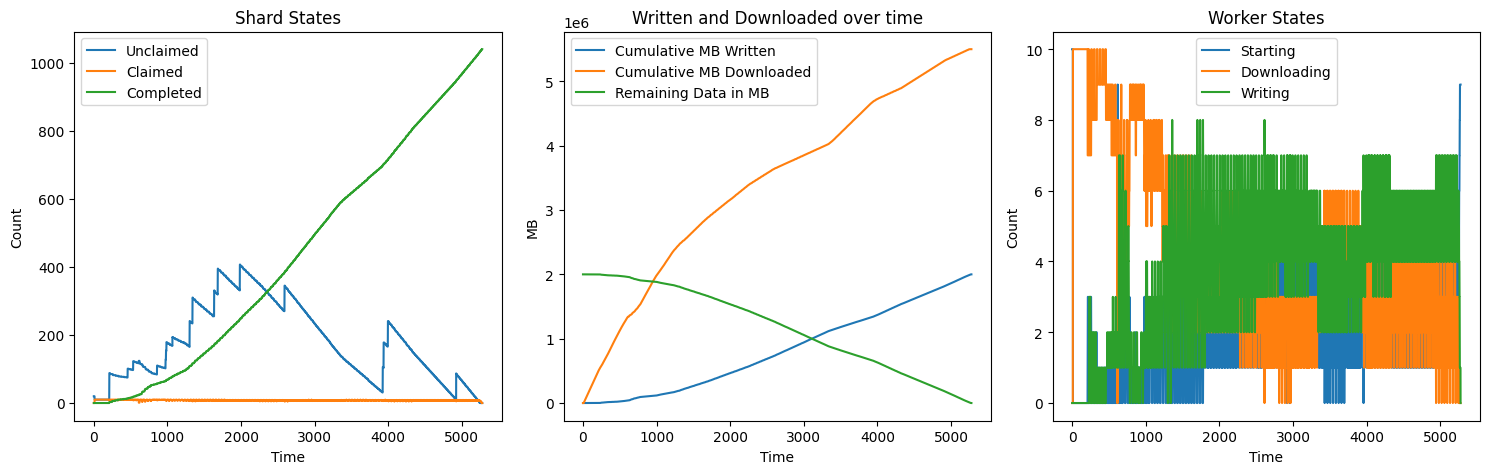

In [17]:
large_shard_universe = UniverseSettings({
    "shards": ([50_000] * 10) + ([150_000] * 10),
    "download_speed_mbps": 250,
    "worker_startup_time_sec": 10,
    "worker_write_speed_mbps": 100,
    "n_workers": 10,
    "model_timeout": 60 * 60 * 2,
})
print(f"Starting work for each model: {sum(large_shard_universe.shards) // 1000 } gb")
print("Full Shard Policy")
_ = run_and_plot_shard_progress(large_shard_universe, full_shard_policy, 'WARN')
print("Checkpoint Policy")
_ = run_and_plot_shard_progress(large_shard_universe, checkpoint_policy, 'WARN')
print("Binary Split Policy")
_ = run_and_plot_shard_progress(large_shard_universe, binary_split_policy, 'WARN')
print("Aggressive Preemptive Split Policy (split to 2gb)")
_ = run_and_plot_shard_progress(large_shard_universe, aggressive_preemptive_split_policy, 'WARN')
print("Conservative Preemptive Split Policy (split to 20gb)")
_ = run_and_plot_shard_progress(large_shard_universe, aggressive_preemptive_split_policy, 'WARN')